# Foundations of Data Analysis : Lab Exercise A2

*Palina Krukovich - a12134146*

<hr style="border:1px solid silver"> </hr>

### General dependencies

In [1]:
import matplotlib.pyplot as plt
from numpy import genfromtxt, mean, sign, diag, dot, round, array_equal
from numpy.linalg import svd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import normalized_mutual_info_score, silhouette_score
from itertools import combinations

### General methods

In [2]:
def read_csv(filename):
    return genfromtxt(filename, delimiter=",", skip_header=1)

def plot(ax, data, colors, title):
    ax.set_title(title)
    ax.scatter(data[:,0], data[:,1], c=colors)

<hr style="border:1px solid silver"> </hr>

## Task-1 Dimensionality Reduction, PCA

File `seeds.csv` contains 8 columns. First 7 columns are seed parameters and the last column is seed type.
We separate those columns: seeds data (1-7 columns) goes to `x`, and types (8th column) goes to `types`.

Then, we apply the PCA and SVD algorithms on `x` to get principal components.

In [3]:
# PCA and SVD algorithms

def compute_pca(x):
    components = PCA(n_components=2).fit(x).transform(x)
    return round(components, 2)

def compute_svd(x, correct_signs):
    u, s, v = svd(x, full_matrices=False)
    components = dot(u, diag(s))[:,:2]
    components *= correct_signs * sign(components) # align mismatched signs
    return round(components, 2)

In [4]:
# Load data

dataset = read_csv("seeds.csv")
x = dataset[:,:7]
types = dataset[:,7]

In [5]:
# Compute principal components

x -= mean(x, axis=0)
pca_components = compute_pca(x)
svd_components = compute_svd(x, sign(pca_components))

In [6]:
# Compare Principal Components generated by SVD and PCA

print(f"Principal components generated by PCA and SVD are equal: {array_equal(pca_components, svd_components)}")

Principal components generated by PCA and SVD are equal: True


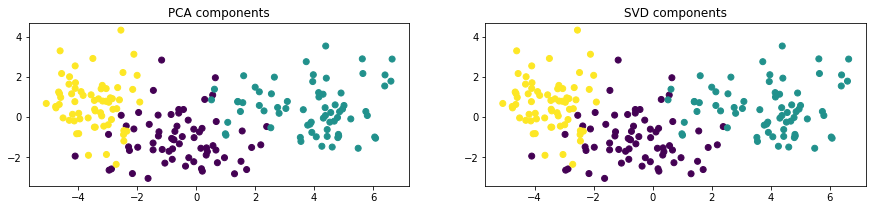

In [7]:
# Plot "Principal Component 1" and "Principal Component 2"

f, axs = plt.subplots(1, 2, figsize=(15,3))
plot(axs[0], pca_components, types, "PCA components")
plot(axs[1], svd_components, types, "SVD components")

###### Curse of dimensionality

For supervised machine learning models the number of samples required to train the model depends on number of features. As the number of dimensions (features) increases, the number of required samples increases exponentially. When there are not enough samples while there are a lot of features the training data becomes sparse which may lead to overfitting.

Unsupervised models (clustering) work based on distance measures. When the data is high-dimensional the distances between points become unreliable and more and more point pairs start having the same distance. This is a reason why some distance measures may work well on low dimensions but lead to completely wrong results on higher dimensions.

Also, the problem is just the size of data. When the number of dimensions is too high, the computations take more time and consume more memory.

To reduce the number of features we use feature extraction. It may be performed manually if we are familiar with the data and have some expert knowledge. Or we can use dimensionality reduction algorithms, like PCA. 

<hr style="border:1px solid silver"> </hr>

## Task-2 Clustering

The following [research](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) was used to help determine the parameters for DBSCAN model.

Four clustering methods where used in this task:

- **DBSCAN**
    - Dataset 1. Parameters: eps = 1.4, min_samples = 7
    - Dataset 2. Parameters: eps = 1.2, min_samples = 6
    - Dataset 3. Parameters: eps = 0.15, min_samples = 4
    - Dataset 4. Parameters: eps = 0.25, min_samples = 10
- **KMeans**
- **Expectation Maximization (EM)**
- **Hierarchical - Average Link**


*Parameters for DBSCAN:*

After some research and test runs it was determined that the minimum number of samples to form a cluster should be at least the number of real clusters in the dataset. If the dataset is noisy than we can increase the value even more. As suggested in the paper the optimal number for `min_samples` is 4 for 2-dimensional data, so I tried only values greater than or equal to 4.

The `eps` parameter was found from the data as an average, from the first look, distance between points inside a cluster. 
There are clusters in those datasets that are not suitable for DBSCAN - clusters of different densities inside one dataset, ex. datasets 2 and 4. In this case I chose the average distance between points inside a highest density cluster, to prevent merging different clusters into one.

*Parameters for KMeans, EM, Hierarchical clustering:*

For other algorithms the only parameter is the number of clusters which was obtained from original dataset as a number of real clusters (which is availbale for us):
- Dataset 1: 7 clusters
- Dataset 2: 6 clusters
- Datastes 3 and 4: 2 clusters

*The name of each chart contains the following information:*
- *Dataset number*
- *Name of the Clustering algorithm*
- *Normalized Mutual Information (NMI), %*
- *Silhouette Score (SS), %*

In [8]:
def format_plot_title(dataset_name, model_name, labels, model_labels, x):
    nmi = normalized_mutual_info_score(labels, model_labels)
    ss = silhouette_score(x, model_labels)
    return f"{dataset_name} - {model_name} - NMI {round(nmi, 2)}, SS {round(ss, 2)}"

def cluster_dataset(dataset, eps, min_samples, k, dataset_name, axs):
    x = dataset[:,:2]
    labels = dataset[:,2]
    
    plot(axs[0], x, labels, dataset_name + " - original")
    
    dbscan_labels = DBSCAN(eps=eps, min_samples=min_samples).fit(x).labels_
    kmeans_labels = KMeans(n_clusters=k).fit(x).labels_
    em_labels = GaussianMixture(n_components=k).fit(x).predict(x)
    avg_link_labels = AgglomerativeClustering(n_clusters=k, linkage="average").fit(x).labels_
    
    plot(axs[1], x, dbscan_labels, format_plot_title(dataset_name, "dbscan", labels, dbscan_labels, x))
    plot(axs[2], x, kmeans_labels, format_plot_title(dataset_name, "kmeans", labels, kmeans_labels, x))
    plot(axs[3], x, em_labels, format_plot_title(dataset_name, "em", labels, em_labels, x))
    plot(axs[4], x, avg_link_labels, format_plot_title(dataset_name, "avg link", labels, avg_link_labels, x))

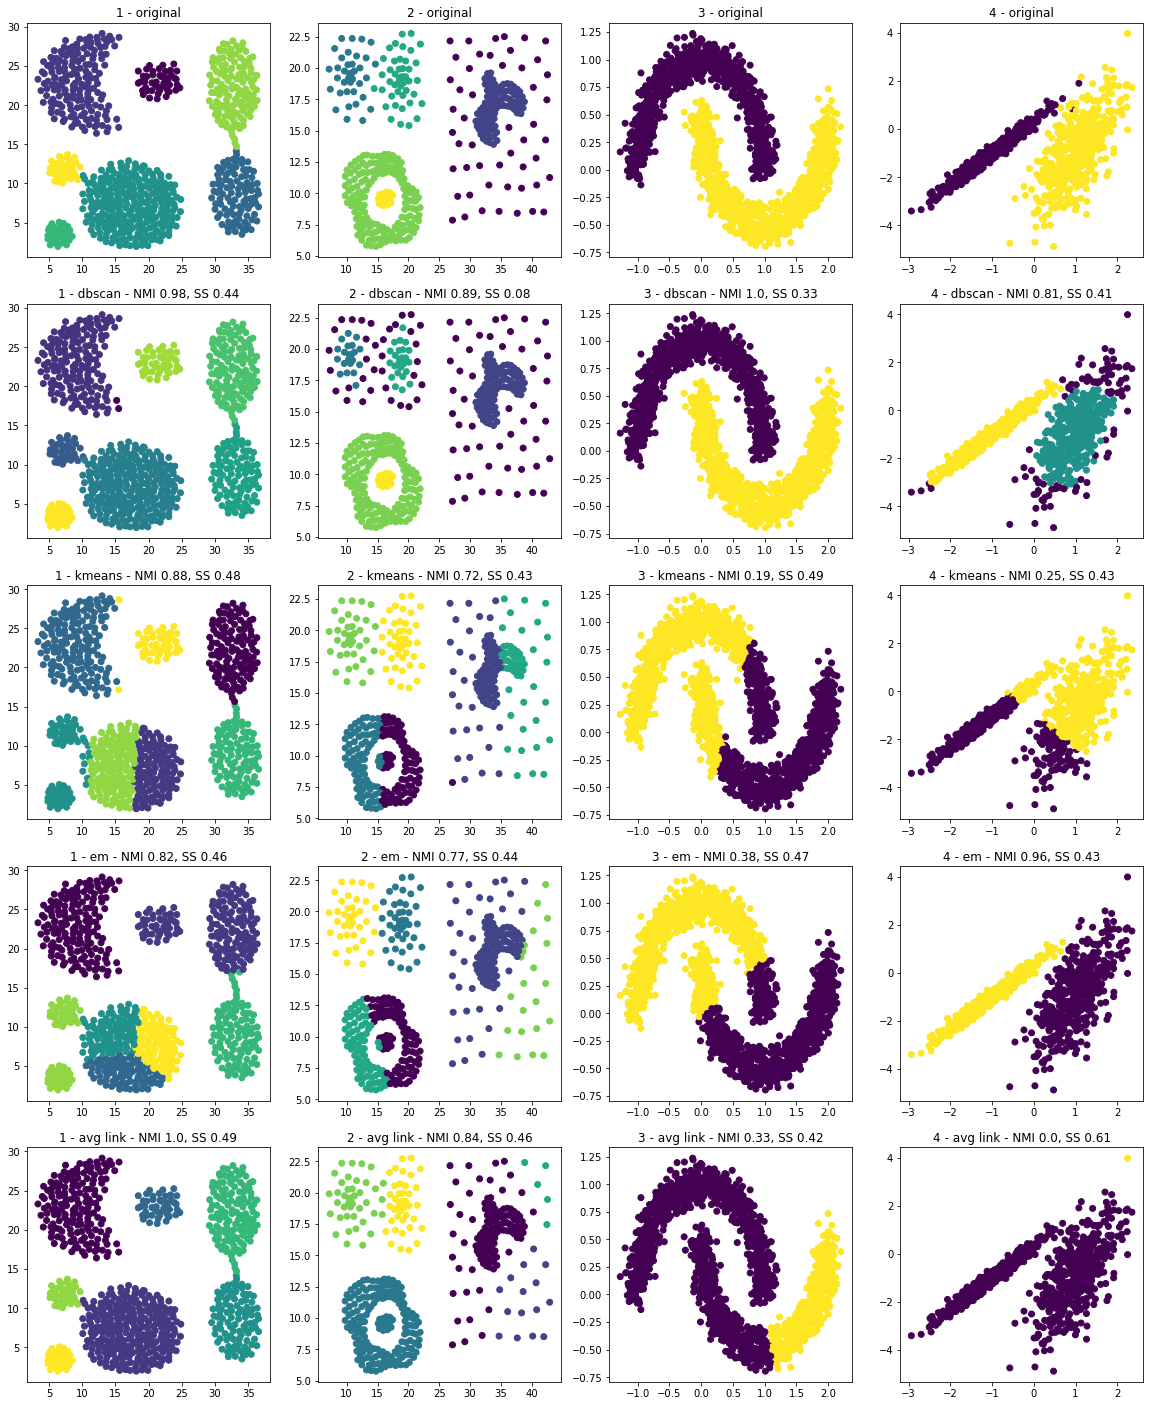

In [9]:
dataset1 = read_csv("dataset1_noCluster7.csv")
dataset2 = read_csv("dataset2_noCluster6.csv")
dataset3 = read_csv("dataset3_noCluster2.csv")
dataset4 = read_csv("dataset4_noCluster2.csv")

f, axs = plt.subplots(5, 4, figsize=(20, 25))

cluster_dataset(dataset1, 1.4, 7, 7, "1", axs[:, 0])
cluster_dataset(dataset2, 1.2, 6, 6, "2", axs[:, 1])
cluster_dataset(dataset3, 0.15, 4, 2, "3", axs[:, 2])
cluster_dataset(dataset4, 0.25, 10, 2, "4", axs[:, 3])

*NMI - normalized mutual information, SS - Silhouette Score*.

As we can see from the charts DBSCAN clustered well all the datasets. For Datasets 1 and 3 it determined the clusters correctly, the NMI is almost 1, this is because the clusters have the same density and are well apart from each other. For datasets 2 and 4 it clustered more points as noisy points because those datasets have clusters with different density, but the NMI is high (> 0.8) and almost all the clusters were found correctly. 

KMeans performed worse than DBSCAN. It has high NMI score only on the Datasets 1 and 2. KMeans makes the assumptions that the data is spherical and that clusters have the same number of samples, so it did well on clusters that sattisfy these assumptions, and failed on other clusters (clusters are of different size or are of a unusual shape).

Expectations maximization algorithm tries to find the distribution of data, assuming that data has Gaussian mixture distribution with different parameters for each cluster. This why it did not cluster the Dataset 3 because it is not Gaussian and had some incorrect results in Datasets 1 and 2. Nevertheless, it did well on the Dataset 4 (NMI = 0.96), because this dataset sattisfies the EM assumption.

Hierarchical clustering with average linkage merges the clusters based on smallest average distance between points. When the clusters are well-separated, like in Dataset 1, it performs very good (NMI = 1). In the Dataset 3 we see "chain-like"  clusters, here single linkage method would perform better (see below). Hierarchical clustering does not make any assumption on data distribution, it works based on distances, also it does not filter noisy points so it performes worse on a Dataset 4, it merged two clusters into a one large cluster, and classified a single point which is placed far from others as a separate cluster. 

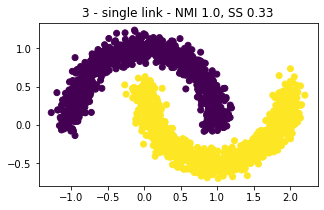

In [10]:
f, axs = plt.subplots(1, 1, figsize=(5, 3))

# Cluster dataset 3 using Agglomerative Clustering with single linkage
x3 = dataset3[:,:2]
labels3 = dataset3[:,2]
cluster_labels3 = AgglomerativeClustering(n_clusters=2, linkage="single").fit(x3).labels_
plot(axs, x3, cluster_labels3, format_plot_title("3", "single link", labels3, cluster_labels3, x3))


<hr style="border:1px solid silver"> </hr>

## Task-3 Apriori Algorithm


In [11]:
# Apriori algorithm

def search_frequent(candidates, minsup, itemsets, candidates_sup, frequent_sup):
    frequent = set()
    for candidate in candidates:
        for itemset in itemsets:
            if candidate.issubset(itemset):
                candidates_sup[candidate] = candidates_sup[candidate] + 1 if candidate in candidates_sup else 1
        if candidates_sup[candidate] / len(itemsets) >= minsup:
            frequent.add(candidate)
            frequent_sup[candidate] = candidates_sup[candidate]
    return frequent

def search_candidates(frequent, n):
    return {freq1.union(freq2) for freq1 in frequent for freq2 in frequent if len(freq1.union(freq2)) == n}
    
def prune(candidates, frequent, n):
    pruned_candidates = set()
    for candidate in candidates:
        subsets = combinations(candidate, n)
        all_present = True
        for subset in subsets:
            if frozenset(subset) not in frequent:
                all_present = False
                break
        if all_present:
            pruned_candidates.add(candidate)
    return pruned_candidates
    
def apriori(itemsets, minsup):
    candidates_sup = dict()
    frequent_sup = dict()
    candidates = {frozenset([item]) for itemset in itemsets for item in itemset}
    frequent = search_frequent(candidates, minsup, itemsets, candidates_sup, frequent_sup)
    n = 2
    while frequent:
        candidates = search_candidates(frequent, n)
        candidates = prune(candidates, frequent, n - 1)
        frequent = search_frequent(candidates, minsup, itemsets, candidates_sup, frequent_sup)
        n += 1
    return frequent_sup

In [12]:
# Load data
movies = list()
with open("movies.txt", "r") as f:
    for line in f.readlines(): 
        movies.append(frozenset(line.strip().split(";")))

In [13]:
# Run the algorithm
all_frequent_itemsets = apriori(movies, 0.05)

In [14]:
# Write results to files
def format_line(itemset, support):
    return f"{support}:{';'.join(itemset)}\n"

with open("oneItems.txt", "w") as f:
    for itemset, support in all_frequent_itemsets.items():
        if len(itemset) == 1:
            f.write(format_line(itemset, support))

with open("patterns.txt", "w") as f:
    for itemset, support in all_frequent_itemsets.items():
        if len(itemset) > 1:
            f.write(format_line(itemset, support))

In [15]:
# Recommend movie
user_movies = frozenset({"Ant-Man and the Wasp", "Spider-Man: Far from Home"})
user_movies_support = all_frequent_itemsets[user_movies]

max_confidence = 0
recommendation = ""
for itemset, support in all_frequent_itemsets.items():
    if user_movies.issubset(itemset) and len(itemset) > 2:
        confidence = support / user_movies_support
        if confidence > max_confidence:
            max_confidence = confidence
            recommendation = list(itemset - user_movies)[0]

print(f"Movie: {recommendation}")
print(f"Confidence: {round(max_confidence * 100, 2)}%")

Movie: Avengers: Infinity War - Part II
Confidence: 96.34%
